In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/course22/paddy-disease-classification.zip" -d "/content/drive/MyDrive/course22/paddy-disease-classification"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/train_images/normal/108806.jpg  
  inflating: /content/drive/MyDrive/course22/paddy-disease-classification/__MACOSX/paddy-disease-classification/train_images/normal/._108806.jpg  
  inflating: /content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/train_images/normal/108812.jpg  
  inflating: /content/drive/MyDrive/course22/paddy-disease-classification/__MACOSX/paddy-disease-classification/train_images/normal/._108812.jpg  
  inflating: /content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/train_images/normal/103947.jpg  
  inflating: /content/drive/MyDrive/course22/paddy-disease-classification/__MACOSX/paddy-disease-classification/train_images/normal/._103947.jpg  
  inflating: /content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classificati

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# !unzip paddy-disease-classification.zip

In [ ]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

## Getting set up

In [ ]:
from pathlib import Path

comp = "/content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification"
path = Path(comp)
print(path.ls() if hasattr(path, 'ls') else list(path.iterdir()))


[Path('/content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/test_images'), Path('/content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/train.csv'), Path('/content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/train_images'), Path('/content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/sample_submission.csv')]


In [ ]:
!pip install fastai "timm>=0.6.2.dev0"

In [ ]:
from fastai.vision.all import *

dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=Resize(224))

In [ ]:
path

Path('/content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification')

In [ ]:
from fastai.vision.all import *
set_seed(42)

path.ls()

[Path('/content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/test_images'), Path('/content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/train.csv'), Path('/content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/train_images'), Path('/content/drive/MyDrive/course22/paddy-disease-classification/paddy-disease-classification/sample_submission.csv')]

## Looking at the data

In [ ]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


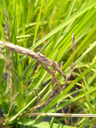

In [ ]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [ ]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

,count
"(480, 640)",10403
"(640, 480)",4


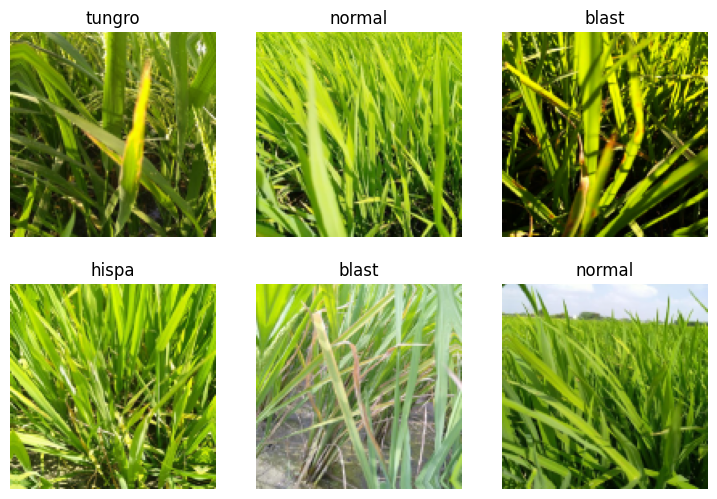

In [ ]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

## Our first model

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

<div></div>

SuggestedLRs(valley=0.0010000000474974513, slide=0.001737800776027143)

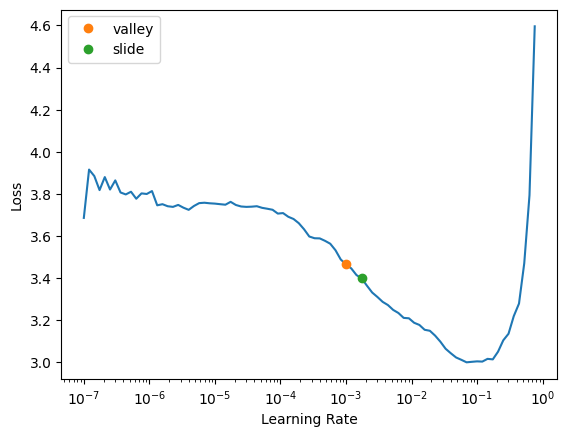

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
!pip install --upgrade fastprogress


In [ ]:
from fastai.callback.progress import ProgressCallback

learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()
learn.remove_cb(ProgressCallback)
learn.fine_tune(3,0.01)



[0, 2.022658586502075, 1.2432430982589722, 0.401729941368103, '02:01']
[0, 1.2957614660263062, 0.9070738554000854, 0.2964920699596405, '01:54']
[1, 1.0164966583251953, 0.712367832660675, 0.2364247888326645, '01:54']
[2, 0.8585577011108398, 0.6643075942993164, 0.22345025837421417, '02:03']


## Predictions to csv

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [ ]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [ ]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([4, 8, 4,  ..., 8, 1, 5])

In [ ]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [ ]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

,idxs
0,brown_spot
1,normal
2,brown_spot
3,blast
4,blast
...,...
3464,dead_heart
3465,normal
3466,normal
3467,bacterial_leaf_streak


In [ ]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,brown_spot
200002.jpg,normal
200003.jpg,brown_spot
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,normal


In [52]:
learn.export("model.pkl")